**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for scientific use. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Georeferencing Multi-Channel ASI Data**
---

### **Datasets**
All datasets can be found at https://data.phys.ucalgary.ca. This crib sheet currently pertains to the following datasets:
- TREx RGB
- *Rainbow ASI - Coming Soon*
- *SMILE ASI - Coming Soon*

</br>

### **Crib Sheet Summary**
This crib sheet projects several TREx RGB images onto a geographic map. With some thought, these methods can be applied to other multi-channel image datasets.



</br>

---

</br>


## **Install dependencies**

Here we'll install [PyAuroraX](https://github.com/aurorax-space/pyaurorax), and import it.

Some helpful links:
  - [PyAuroraX documentation](https://docs.aurorax.space/code/overview)
  - [PyAuroraX API Reference](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax)
  - [Jupyter notebook examples](https://github.com/aurorax-space/pyaurorax/tree/main/examples/notebooks)


In [1]:
!pip install pyaurorax

In [13]:
import datetime
import pprint
import cartopy
import pyaurorax
from tqdm.auto import tqdm

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## **Downloading Data**

We need to download the data we're going to be using. PyAuroraX provides functions to handle this for you. You can learn more about how to use them by looking at the 'Data download` crib sheet, reading the PyAuroraX documentation, or the PyAuroraX API reference. Links are above.

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible. You would download the data and skip to the data reading step of this crib sheet.

In [2]:
# download an hour of TREx RGB data from Rabbit Lake
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 5, 30)
end_dt = datetime.datetime(2023, 2, 24, 6, 29)
site_uid = "rabb"
r_raw_1hr = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

# download 1 minute of data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = datetime.datetime(2023, 2, 24, 6, 15)
site_uid = "rabb"
r_raw_allsites = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

# download skymaps
r_skymaps = {}
for site_uid in tqdm(["yknf", "gill", "rabb", "luck", "atha"], desc="Downloading skymaps", unit="skymap"):
    r_skymaps[site_uid] = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, timestamp=datetime.datetime(2023, 2, 24))

## **Georeferencing Keograms**

Creating keograms is covered in the 'Loading, Calibrating, and Plotting Multi Channel ASI Data' crib sheet, but it is often useful to be able to georeference a koegram's axes.

In [3]:
# read in an hour of TREx RGB data
data = aurorax.data.ucalgary.read(r_raw_1hr.dataset, r_raw_1hr.filenames, n_parallel=2)
data.pretty_print()

Data:
  data                  : array(dims=(480, 553, 3, 1200), dtype=uint8)
  timestamp             : [1200 datetimes]
  metadata              : [1200 dictionaries]
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=TREX_RGB_RAW_NOMINAL, short_description='TREx RGB All Sky Imag...)


For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid from the date it is produced, until it is superseded by another file.

Be sure you choose the correct skymap for your data timeframe. You can view all skymaps by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/), or use the PyAuroraX `get_urls()` or `download()` functions. If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf

In [4]:
# read in the skymap for this site
#
# NOTE: we'll use the download object we saved up above, but you can alternatively 
# specify the filename manually, or use glob to find it on your computer
skymap_file = r_skymaps["rabb"].filenames[0]
print(skymap_file)
print()

# read in the file
skymap_data = aurorax.data.ucalgary.read(r_skymaps["rabb"].dataset, skymap_file)
skymap_data.pretty_print()
print()
skymap_data.data[0].pretty_print()

C:\Users\darrenc\pyaurorax_data\TREX_RGB_SKYMAP_IDLSAV\rabb\rabb_20220301\rgb_skymap_rabb_20220301-+_v01.sav

Data:
  data                  : [1 Skymap object]
  timestamp             : []
  metadata              : []
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=TREX_RGB_SKYMAP_IDLSAV, short_description='TREx RGB All Sky Im...)

Skymap:
  filename               : C:\Users\darrenc\pyaurorax_data\TREX_RGB_SKYMAP_IDLSAV\rabb\rabb_20220301\rgb_skymap_rabb_20220301-+_v01.sav
  full_azimuth           : array(dims=(480, 553), dtype=>f4)
  full_elevation         : array(dims=(480, 553), dtype=>f4)
  full_map_altitude      : array(dims=(3,), dtype=>f4)
  full_map_latitude      : array(dims=(3, 481, 554), dtype=>f4)
  full_map_longitude     : array(dims=(3, 481, 554), dtype=>f4)
  generation_info        : SkymapGenerationInfo(...)
  get_precalculated_altitudes: <bound method Skymap.get_precalculated_altitudes of Skymap(project_uid=rgb, site_u

In [6]:
# scale the images
images_scaled = at.scale_intensity(data.data, min=15, max=100)

# create a keogram
keogram = at.keogram.create(images_scaled, data.timestamp)

In [7]:
# set the geographic coordinates
keogram.set_geographic_latitudes(skymap_data.data[0])

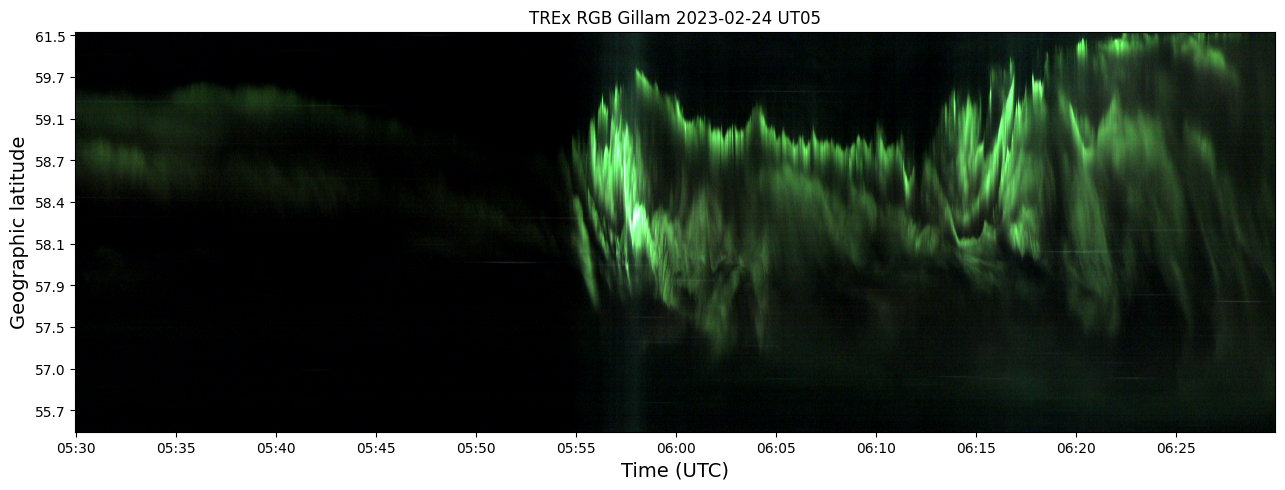

In [8]:
# plot the data
keogram.plot(
    figsize=(12, 4),
    y_type="geo",
    aspect="auto",
    title="TREx RGB Gillam %s" % (data.timestamp[0].strftime("%Y-%m-%d UT%H")),
)

## **Geomagnetic Coordinates**

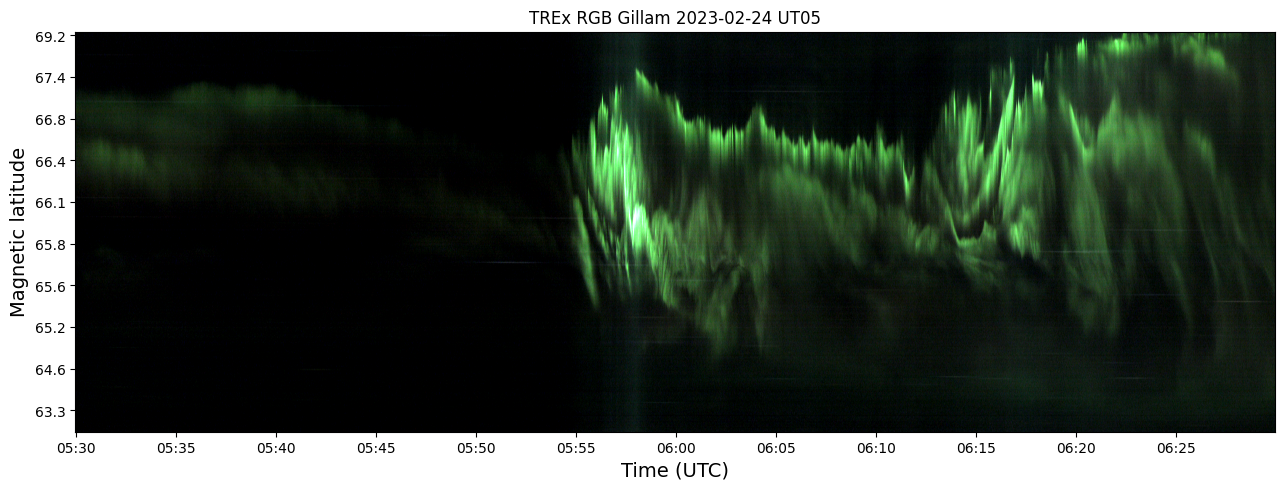

In [10]:
# set the geomagnetic latitudes
keogram.set_magnetic_latitudes(skymap_data.data[0], data.timestamp[0])

# plot the data
keogram.plot(
    figsize=(12, 4),
    y_type="mag",
    aspect="auto",
    title="TREx RGB Gillam %s" % (data.timestamp[0].strftime("%Y-%m-%d UT%H")),
)

## **Creating a Mosaic**

The process of making a mosaic involves properly accounting for the mapping of each pixel. Due to the fisheye optics, the pixels become increasingly large as you move away from zenith, to lower elevation angles.

  Our methodology for creating mosaics relies on two key points.


1.   we must accurately account for the changing (and unique) pixel areas and locations in geodetic coordinates, and
2.   when putting multiple imagers together, we want to use the information from the closest camera

Our methodology involves creating exact polygons for each pixel (this is why the skymap contains the pixel corners!), for each camera and filling those polygons with the correct (scaled, or calibrated) imager data. This methodology ensures accuracy of all pixels within the FoV.

The procedure for making a mosaic is best done in 1D vector space.  Below you will find functions that convert the skymaps and images to vectors, before plotting those vectors.

## **Building a mosaic**
In general, before building a mosaic you'll want to verify what sites you should use by looking at the [summary data](https://data-portal.phys.ucalgary.ca/archive/trex_rgb/keograms/hourMode?datestring=2023/02/24&hourSelected=ut06&site_selected=all). In this case, the summary data clearly shows that Fort Smith had a different color profile than the other RGB cameras. The data is still useable, however in multi-imager studies Fort Smith's instrument response cannot be directly intercompared with, for example Rabbit, because of the color offset. This was an operational issue at Fort Smith.

For this event, it is far more advantageous to use Yellowknife (a recent installation of RGB) which has singificant overlap with Fort Smith but did not have the color profile issue.


In [11]:
# read the skymap data
#
# NOTE: the order of the sites here is very important, as that order MUST be the same
# for both the skymap and image data we pass into the mosaic prep routines.
dataset = r_skymaps["yknf"].dataset
skymap_file_list = [
    r_skymaps["yknf"].filenames[0],
    r_skymaps["gill"].filenames[0],
    r_skymaps["rabb"].filenames[0],
    r_skymaps["luck"].filenames[0],
    r_skymaps["atha"].filenames[0],
]
skymap_data = aurorax.data.ucalgary.read(dataset, skymap_file_list, n_parallel=2)
skymap_data.pretty_print()

Data:
  data                  : [5 Skymap objects]
  timestamp             : []
  metadata              : []
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=TREX_RGB_SKYMAP_IDLSAV, short_description='TREx RGB All Sky Im...)


In [14]:
# read in the image data
#
# to change it up a bit, we'll use glob to find the filenames
import pathlib
dataset = r_raw_allsites.dataset
root_path = pathlib.Path(aurorax.download_output_root_path)

# NOTE: the order of the sites here is very important, as that order MUST be the same
# for both the skymap and image data we pass into the mosaic prep routines.
image_file_list = [
    list(root_path.glob("TREX_RGB_RAW_NOMINAL/2023/02/24/yknf*/ut06/20230224_0615*"))[0],    
    list(root_path.glob("TREX_RGB_RAW_NOMINAL/2023/02/24/gill*/ut06/20230224_0615*"))[0],    
    list(root_path.glob("TREX_RGB_RAW_NOMINAL/2023/02/24/rabb*/ut06/20230224_0615*"))[0],    
    list(root_path.glob("TREX_RGB_RAW_NOMINAL/2023/02/24/luck*/ut06/20230224_0615*"))[0],    
    list(root_path.glob("TREX_RGB_RAW_NOMINAL/2023/02/24/atha*/ut06/20230224_0615*"))[0],    
]
pprint.pprint(image_file_list)
print()

image_data_list = []
for f in image_file_list:
    image_data_list.append(aurorax.data.ucalgary.read(dataset, f))
pprint.pprint(image_data_list)

[WindowsPath('C:/Users/darrenc/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/yknf_rgb-08/ut06/20230224_0615_yknf_rgb-08_full.h5'),
 WindowsPath('C:/Users/darrenc/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/gill_rgb-04/ut06/20230224_0615_gill_rgb-04_full.h5'),
 WindowsPath('C:/Users/darrenc/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/rabb_rgb-06/ut06/20230224_0615_rabb_rgb-06_full.h5'),
 WindowsPath('C:/Users/darrenc/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/luck_rgb-03/ut06/20230224_0615_luck_rgb-03_full.h5'),
 WindowsPath('C:/Users/darrenc/pyaurorax_data/TREX_RGB_RAW_NOMINAL/2023/02/24/atha_rgb-07/ut06/20230224_0615_atha_rgb-07_full.h5')]

[Data(data=array(dims=(480, 553, 3, 20), dtype=uint8), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=None, dataset=Dataset(name=TREX_RGB_RAW_NOMINAL, short_description='TREx RGB All Sky Imag...)),
 Data(data=array(dims=(480, 553, 3, 20), dtype=uint8), timestamp=[20 datetimes], metadata=[20 di

In [15]:
# if we're not sure which altitudes are pre-computed, we can see them inside a skymap file
#
# if you choose different altitude when preparing the skymap data, the function will take longer
# to process as it performs an interpolation between the pre-computed altitudes

print("Available pre-computed altitudes: %s" % (', '.join(["%d" % (x) for x in skymap_data.data[0].get_precalculated_altitudes()])))

Available pre-computed altitudes: 90, 110, 150


In [16]:
# prepare the skymap data
#
# NOTE: this step is not time dependent, so it only needs to be performed once
# per set of skymaps.
prepped_skymap = at.mosaic.prep_skymaps(skymap_data.data, 110, n_parallel=5)
prepped_skymap

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 265440), dtype=float64), polyfill_lon=array(dims=(5, 265440), dtype=float64), elevation=array(dims=(265440,), dtype=float32), site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'atha'])

In [18]:
# prepare the image data
prepped_images = at.mosaic.prep_images(image_data_list)
prepped_images

MosaicData(images=Dict[5 sites of array(dims=(480, 553))], timestamps=[20 timestamps], site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'atha'])

In [21]:
# define the intensity scales for each site
#
# NOTE: you can define intensity scale for each site 
# separately, all sites as a whole, or not at all. We
# choose to use a scale for all sites below. Refer to 
# the single channel crib sheet to see how to scale on 
# a per-site basis.
scale = [10, 150]

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, frame_num, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


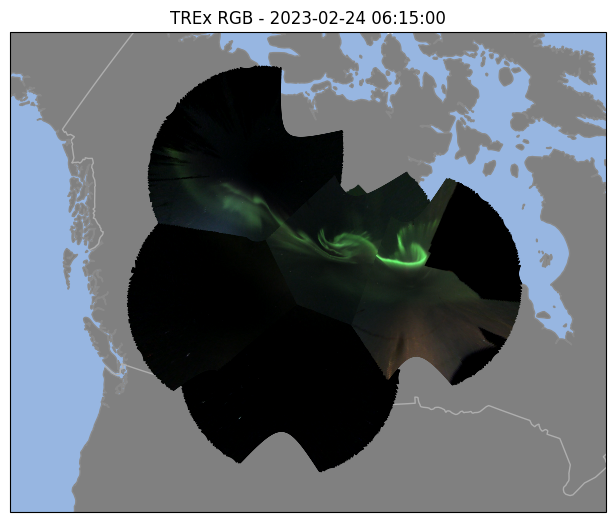

In [22]:
# plot mosaic
map_extent = [-130, -80, 40, 70]
mosaic.plot(map_extent, title="TREx RGB - %s" % (image_data_list[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))